In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')

In [4]:
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
df = df.drop(columns=['id', 'url_legal', 'license', 'standard_error'])

In [6]:
print(df.isnull().sum())

excerpt    0
target     0
dtype: int64


In [7]:
X = df["excerpt"]
Y = df["target"]

In [8]:
import re
def text_cleaning(text):
  # cleaned_text = re.sub(r"[,.;@#?!&$]+\*", " ", text)
  cleaned_text = " ".join(re.findall("[a-zA-Z?!,.]+", text))

  return cleaned_text

In [9]:
X = X.apply(lambda x: text_cleaning(x))

In [10]:
X[0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape. The floor was covered with snow white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches. At each end of the room, on the wall, hung a beautiful bear skin rug. These rugs were for prizes, one for the girls and one for the boys. And this was the game. The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole. This would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [11]:
token = tf.keras.preprocessing.text.Tokenizer(lower = True)

token.fit_on_texts(X)

X_train = token.texts_to_sequences(X)

In [12]:
MAX_SEQ_LEN = 0
for i in X_train:
  if len(i) > MAX_SEQ_LEN:
    MAX_SEQ_LEN = len(i)

print(MAX_SEQ_LEN)

218


In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen = 215, padding = 'post', truncating='post')

In [14]:
vocab_size = len(token.word_index) + 1
vocab_size

26236

In [15]:
from tqdm import tqdm
embedding_vector = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:], dtype = 'float32')
    embedding_vector[word] = coef

2196018it [04:26, 8255.07it/s]


In [16]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
      embedding_matrix[i] = embedding_value

100%|██████████| 26235/26235 [00:00<00:00, 231221.39it/s]


In [17]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = 200, trainable = False))
    model.add(tf.keras.layers.LSTM(75))
    model.add(tf.keras.layers.Dense(1))

    return model

In [18]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(beta_1=0.95),
              loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError()]
             )

history = model.fit(X_train, Y, batch_size = 2272, epochs = 190, validation_split = 0.2)

Epoch 1/190
1/1 [==============================] - 9s 9s/step - loss: 2.0810 - root_mean_squared_error: 1.4426 - val_loss: 1.5839 - val_root_mean_squared_error: 1.2585
Epoch 2/190
1/1 [==============================] - 0s 321ms/step - loss: 2.0417 - root_mean_squared_error: 1.4289 - val_loss: 1.5494 - val_root_mean_squared_error: 1.2447
Epoch 3/190
1/1 [==============================] - 0s 388ms/step - loss: 2.0007 - root_mean_squared_error: 1.4145 - val_loss: 1.5093 - val_root_mean_squared_error: 1.2285
Epoch 4/190
1/1 [==============================] - 0s 358ms/step - loss: 1.9531 - root_mean_squared_error: 1.3975 - val_loss: 1.4605 - val_root_mean_squared_error: 1.2085
Epoch 5/190
1/1 [==============================] - 0s 321ms/step - loss: 1.8950 - root_mean_squared_error: 1.3766 - val_loss: 1.4002 - val_root_mean_squared_error: 1.1833
Epoch 6/190
1/1 [==============================] - 0s 319ms/step - loss: 1.8230 - root_mean_squared_error: 1.3502 - val_loss: 1.3256 - val_root_mean

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          7870800   
_________________________________________________________________
lstm (LSTM)                  (None, 75)                112800    
_________________________________________________________________
dense (Dense)                (None, 1)                 76        
Total params: 7,983,676
Trainable params: 112,876
Non-trainable params: 7,870,800
_________________________________________________________________


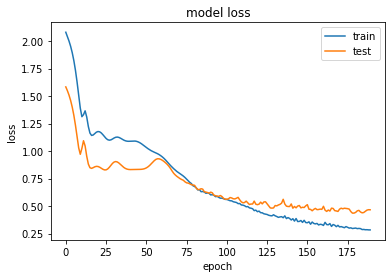

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [21]:
test=pd.read_csv("../input/commonlitreadabilityprize/test.csv")

In [22]:
test.shape

(7, 4)

In [23]:
X_test=test['excerpt']

In [24]:
print(X_test.isnull().sum())

0


In [25]:
X_test.head()

0    My hope lay in Jack's promise that he would ke...
1    Dotty continued to go to Mrs. Gray's every nig...
2    It was a bright and cheerful scene that greete...
3    Cell division is the process by which a parent...
4    Debugging is the process of finding and resolv...
Name: excerpt, dtype: object

In [26]:
X_test = X_test.apply(lambda x: text_cleaning(x))

In [27]:
X_test = token.texts_to_sequences(X_test)

In [28]:
X_test=tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = 215, padding = 'post', truncating='post')

In [29]:
y_pred=model.predict(X_test)

In [30]:
y_pred

array([[-0.3156986 ],
       [-0.06831311],
       [-0.92505604],
       [-2.4265842 ],
       [-1.2728721 ],
       [ 0.301638  ],
       [ 0.38756555]], dtype=float32)

In [31]:
test=pd.DataFrame(test,columns=['id'])


In [32]:
test['target']=0

In [33]:
test.head()

,id,target
0,c0f722661,0
1,f0953f0a5,0
2,0df072751,0
3,04caf4e0c,0
4,0e63f8bea,0


In [34]:
test.shape

(7, 2)

In [35]:
for i in range(test.shape[0]):
    test.iloc[i,1]=y_pred[i]

In [36]:
test.head()

,id,target
0,c0f722661,-0.315699
1,f0953f0a5,-0.068313
2,0df072751,-0.925056
3,04caf4e0c,-2.426584
4,0e63f8bea,-1.272872


In [37]:
test.to_csv(r"./submission.csv",index=False)